In [5]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

url = "https://budget.finance.go.ug/content/national-budget-performance-reports-2"
base_url = "https://budget.finance.go.ug"

response = requests.get(url)
soup = BeautifulSoup(response.text, "html.parser")

pdf_links = []
for link in soup.find_all("a", href=True):
    href = link["href"]
    if href.endswith(".pdf"):
        full_url = urljoin(base_url, href)
        pdf_links.append(full_url)

# Preview first 5 corrected links
print(pdf_links[:5])


['https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%202009-10.pdf']


In [7]:
import os

os.makedirs("budget_reports", exist_ok=True)

for i, pdf_url in enumerate(pdf_links):
    r = requests.get(pdf_url)
    with open(f"budget_reports/report_{i+1}.pdf", "wb") as f:
        f.write(r.content)


In [9]:
import pdfplumber
import pandas as pd

all_data = []

with pdfplumber.open("budget_reports/report_1.pdf") as pdf:
    for page in pdf.pages:
        tables = page.extract_tables()
        for table in tables:
            df = pd.DataFrame(table[1:], columns=table[0])  # skip header
            all_data.append(df)

# Preview first extracted table
all_data[0].head()


,,Road,,,FY2009/10 Target,,,Actual FY2009/10,None,
0,Fort-Portal – Bundibugyo -Lamia\n(104Km),None,None,(25%),None,None,,5%,None,
1,None,None,None,None,None,None,,None,None,None
2,Kabale – Kisoro – Bunagana\n(98Km),None,None,(30%),None,None,,29%,None,
3,None,None,None,None,None,None,,None,None,None
4,Dokolo – Lira (60.4Km),None,None,45%,None,None,,46%,None,


In [11]:
df_combined = pd.concat(all_data, ignore_index=True)
df_combined.to_csv("health_agriculture_execution_fy2023.csv", index=False)


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [13]:
all_data = []

with pdfplumber.open("budget_reports/report_1.pdf") as pdf:
    for page in pdf.pages:
        tables = page.extract_tables()
        for table in tables:
            try:
                df = pd.DataFrame(table[1:], columns=table[0])
                # Drop columns with duplicate names
                df = df.loc[:, ~df.columns.duplicated()]
                all_data.append(df)
            except Exception as e:
                print("Skipping a malformed table:", e)


In [14]:
for i, df in enumerate(all_data):
    print(f"Table {i+1} columns: {df.columns.tolist()}")


Table 1 columns: ['', 'Road', 'FY2009/10 Target', 'Actual FY2009/10', None]
Table 2 columns: ['', 'Indicator', 'Annual Target', 'Annual', '% completion']
Table 3 columns: ['', 'Indicator', 'Annual Target', 'Annual', '% completion']
Table 4 columns: ['', 'Indicator', 'Annual Planned (FY', 'Annual Performance', '% Completion']
Table 5 columns: ['', 'Planned Annual Rehabilitation', 'Actual Performance FY2009/10']
Table 6 columns: ['', 'Area of Agri-business Development', 'Annual Target', 'End of Year Actual', '% Annual Target']
Table 7 columns: ['', 'Area of', '08-09 Actual', 'Annual Target', 'End of Year Actual', '% of annual']
Table 8 columns: ['', 'Key Indicators', 'Annual', 'End of Year', 'Details']
Table 9 columns: ['', 'Institution', 'FY2009/10', 'Actual', '% of annual']
Table 10 columns: ['', 'Institution', 'FY2009/10 annual', 'Annual', '% of target\nachieved']
Table 11 columns: ['', 'Institution', 'FY2009/10 annual', 'Annual', '% of target\nachieved']
Table 12 columns: ['', 'Descr

In [17]:
import pdfplumber
import pandas as pd

# Keyword → Vote and Sector mapping
sector_map = {
    "Health": {"Vote": "014", "Sector": "Health"},
    "Education": {"Vote": "013", "Sector": "Education"},
    "Agric": {"Vote": "010", "Sector": "Agriculture"}
}

# Your financial year
financial_year = "2022/23"  # Adjust as needed

# Container for final structured records
structured_data = []

# Load the report PDF
pdf_path = "budget_reports/report_1.pdf"  # Replace with your file path

with pdfplumber.open(pdf_path) as pdf:
    for page_num, page in enumerate(pdf.pages):
        tables = page.extract_tables()
        for table in tables:
            try:
                df = pd.DataFrame(table[1:], columns=table[0])
                df = df.loc[:, ~df.columns.duplicated()]

                first_col = df.columns[0]
                for keyword, meta in sector_map.items():
                    match_rows = df[df[first_col].astype(str).str.contains(keyword, case=False, na=False)]
                    for _, row in match_rows.iterrows():
                        subprogram = row[first_col]
                        
                        # Find numeric value in any other column
                        budget_val = None
                        for val in row[1:]:
                            try:
                                val_clean = str(val).replace(",", "").replace("UGX", "").strip()
                                budget_val = float(val_clean)
                                break
                            except:
                                continue

                        if budget_val:
                            structured_data.append({
                                "Vote": meta["Vote"],
                                "Sector": meta["Sector"],
                                "Subprogram": subprogram,
                                "Financial Year": financial_year,
                                "Approved Budget (UGX, Millions)": budget_val,
                                "Released Budget (UGX)": None,
                                "Actual Expenditure (UGX)": None,
                                "Performance (%)": None,
                                "Deviation (UGX)": None,
                                "Execution Status": None
                            })
            except Exception as e:
                print(f"Error parsing table on page {page_num + 1}: {e}")

# Convert and export
df_structured = pd.DataFrame(structured_data)
df_structured.to_csv("structured_sector_budget_data.csv", index=False)
print("✅ Extracted and structured data saved to 'structured_sector_budget_data.csv'")


✅ Extracted and structured data saved to 'structured_sector_budget_data.csv'


In [19]:
import os
import re
import pdfplumber
import pandas as pd

# Folder with your PDFs
pdf_folder = "budget_reports"

# Sector keywords and schema metadata
sector_map = {
    "Health": {"Vote": "014", "Sector": "Health"},
    "Education": {"Vote": "013", "Sector": "Education"},
    "Agric": {"Vote": "010", "Sector": "Agriculture"}
}

# Schema columns
schema_columns = [
    "Vote", "Sector", "Subprogram", "Financial Year",
    "Approved Budget (UGX, Millions)", "Released Budget (UGX)",
    "Actual Expenditure (UGX)", "Performance (%)",
    "Deviation (UGX)", "Execution Status"
]

structured_records = []

def extract_year_from_filename(filename):
    match = re.search(r"(20\d{2})[-_ ]?(20\d{2})", filename)
    if match:
        return f"{match.group(1)[-2:]}/{match.group(2)[-2:]}"
    return "Unknown"

for filename in os.listdir(pdf_folder):
    if not filename.lower().endswith(".pdf"):
        continue

    year = extract_year_from_filename(filename)
    path = os.path.join(pdf_folder, filename)
    print(f"📄 Processing: {filename} → FY {year}")

    with pdfplumber.open(path) as pdf:
        for page_num, page in enumerate(pdf.pages):
            try:
                tables = page.extract_tables()
                for table in tables:
                    df = pd.DataFrame(table[1:], columns=table[0])
                    df = df.loc[:, ~df.columns.duplicated()]
                    first_col = df.columns[0]

                    for keyword, meta in sector_map.items():
                        matches = df[df[first_col].astype(str).str.contains(keyword, case=False, na=False)]
                        for _, row in matches.iterrows():
                            subprogram = row[first_col]
                            # Attempt to extract numeric budget value
                            budget_val = None
                            for val in row[1:]:
                                try:
                                    val_clean = str(val).replace(",", "").replace("UGX", "").strip()
                                    budget_val = float(val_clean)
                                    break
                                except:
                                    continue
                            if budget_val:
                                structured_records.append({
                                    "Vote": meta["Vote"],
                                    "Sector": meta["Sector"],
                                    "Subprogram": subprogram,
                                    "Financial Year": year,
                                    "Approved Budget (UGX, Millions)": budget_val,
                                    "Released Budget (UGX)": None,
                                    "Actual Expenditure (UGX)": None,
                                    "Performance (%)": None,
                                    "Deviation (UGX)": None,
                                    "Execution Status": None
                                })
            except Exception as e:
                print(f"⚠️ Error on page {page_num+1} of {filename}: {e}")

# Convert to DataFrame
df_final = pd.DataFrame(structured_records)[schema_columns]

# Save to CSV
df_final.to_csv("all_structured_sector_budget_data.csv", index=False)
print("✅ Final CSV saved as 'all_structured_sector_budget_data.csv'")


📄 Processing: report_1.pdf → FY Unknown
✅ Final CSV saved as 'all_structured_sector_budget_data.csv'


In [21]:
import IPython.display as disp
disp.display(df_final)


,Vote,Sector,Subprogram,Financial Year,"Approved Budget (UGX, Millions)",Released Budget (UGX),Actual Expenditure (UGX),Performance (%),Deviation (UGX),Execution Status
0,010,Agriculture,"312204 Taxes on Machinery, Furniture & Vehicle...",Unknown,46.10,None,None,None,None,None
1,010,Agriculture,VF:0181 Agriculture Advisory Services\n321429 ...,Unknown,117.24,None,None,None,None,None
2,014,Health,321432 Health Training Schools,Unknown,1.89,None,None,None,None,None
3,010,Agriculture,224001 Medical and Agricultural supplies 21.41...,Unknown,84.19,None,None,None,None,None
4,014,Health,VF:0881 Primary Healthcare\n321407 District PH...,Unknown,192.90,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
61,013,Education,VF:1454 Revenue Collection & Administration\nC...,Unknown,105.45,None,None,None,None,None
62,010,Agriculture,VF:1455 Statistical production and Services\nC...,Unknown,20.78,None,None,None,None,None
63,010,Agriculture,Output Class: Outputs Provided\n211103 Allowan...,Unknown,58.87,None,None,None,None,None
64,013,Education,VF:1621 Regional and International Co-operatio...,Unknown,5.22,None,None,None,None,None


In [27]:
import re

# Updated sector map with more keyword variants
sector_map = {
    "Health": {"Vote": "014", "Sector": "Health"},
    "Ministry of Health": {"Vote": "014", "Sector": "Health"},
    "Education": {"Vote": "013", "Sector": "Education"},
    "Ministry of Education": {"Vote": "013", "Sector": "Education"},
    "Agric": {"Vote": "010", "Sector": "Agriculture"},
    "Agriculture": {"Vote": "010", "Sector": "Agriculture"},
    "MAAIF": {"Vote": "010", "Sector": "Agriculture"},
}

def clean_number(val):
    try:
        return float(re.sub(r"[^\d.]", "", str(val)))
    except:
        return None

for page_num, page in enumerate(pdf.pages):
    try:
        tables = page.extract_tables()
        for table in tables:
            df = pd.DataFrame(table[1:], columns=table[0])
            df = df.loc[:, ~df.columns.duplicated()]

            # Check every row, across all columns
            for i, row in df.iterrows():
                row_text = row.astype(str).str.lower().str.cat(sep=" ")
                for keyword, meta in sector_map.items():
                    if keyword.lower() in row_text:
                        # Try to find a subprogram and budget value
                        subprogram = row.iloc[0]  # Default to first column
                        budget_val = None
                        for val in row[1:]:
                            cleaned = clean_number(val)
                            if cleaned is not None:
                                budget_val = cleaned
                                break
                        if budget_val:
                            structured_records.append({
                                "Vote": meta["Vote"],
                                "Sector": meta["Sector"],
                                "Subprogram": subprogram,
                                "Financial Year": year,
                                "Approved Budget (UGX, Millions)": budget_val,
                                "Released Budget (UGX)": None,
                                "Actual Expenditure (UGX)": None,
                                "Performance (%)": None,
                                "Deviation (UGX)": None,
                                "Execution Status": None
                            })
    except Exception as e:
        print(f"⚠️ Error parsing page {page_num + 1}: {e}")


In [29]:
# Schema for ordering
schema_columns = [
    "Vote", "Sector", "Subprogram", "Financial Year",
    "Approved Budget (UGX, Millions)", "Released Budget (UGX)",
    "Actual Expenditure (UGX)", "Performance (%)",
    "Deviation (UGX)", "Execution Status"
]

# Convert and export
df_final = pd.DataFrame(structured_records)[schema_columns]
df_final.to_csv("all_structured_sector_budget_data.csv", index=False)
print(f"✅ Extracted {len(df_final)} structured rows saved to all_structured_sector_budget_data.csv")


✅ Extracted 288 structured rows saved to all_structured_sector_budget_data.csv


In [31]:
import IPython.display as disp
disp.display(df_final)

,Vote,Sector,Subprogram,Financial Year,"Approved Budget (UGX, Millions)",Released Budget (UGX),Actual Expenditure (UGX),Performance (%),Deviation (UGX),Execution Status
0,010,Agriculture,"312204 Taxes on Machinery, Furniture & Vehicle...",Unknown,46.10,None,None,None,None,None
1,010,Agriculture,VF:0181 Agriculture Advisory Services\n321429 ...,Unknown,117.24,None,None,None,None,None
2,014,Health,321432 Health Training Schools,Unknown,1.89,None,None,None,None,None
3,010,Agriculture,224001 Medical and Agricultural supplies 21.41...,Unknown,84.19,None,None,None,None,None
4,014,Health,VF:0881 Primary Healthcare\n321407 District PH...,Unknown,192.90,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
283,014,Health,162,Unknown,981.00,None,None,None,None,None
284,014,Health,162,Unknown,911.00,None,None,None,None,None
285,010,Agriculture,None,Unknown,0.36,None,None,None,None,None
286,014,Health,145,Unknown,1109.00,None,None,None,None,None


In [33]:
from collections import Counter
import pandas as pd

# Summary report
print("\n📊 ========== SUMMARY REPORT ==========")

# Total PDFs scanned
print(f"📁 Total PDF files processed: {len(pdf_files)}")

# Count rows per sector
sector_count = Counter([r["Sector"] for r in structured_records])
print("\n📊 Rows per Sector:")
for sector, count in sector_count.items():
    print(f"   • {sector}: {count} rows")

# Count rows per financial year
fy_count = Counter([r["Financial Year"] for r in structured_records])
print("\n📅 Rows per Financial Year:")
for fy, count in sorted(fy_count.items()):
    print(f"   • {fy}: {count} rows")

# Detect empty files (no matches)
matched_files = set([r.get("Source File") for r in structured_records if r.get("Source File")])
empty_files = set(pdf_files) - matched_files

print(f"\n❌ Files with no relevant sector data: {len(empty_files)}")
for fname in empty_files:
    print(f"   • {fname}")



📊 ========== SUMMARY REPORT ==========


NameError: name 'pdf_files' is not defined

In [35]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Target URL and base
base_url = "https://budget.finance.go.ug"
target_url = "https://budget.finance.go.ug/content/national-budget-performance-reports-2"

# Create destination folder
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Scrape page content
response = requests.get(target_url)
soup = BeautifulSoup(response.text, "html.parser")

# Find and clean all PDF links
pdf_links = []
for link in soup.find_all("a", href=True):
    href = link["href"]
    if href.endswith(".pdf"):
        full_url = urljoin(base_url, href)
        pdf_links.append(full_url)

# Download each PDF
print(f"🔍 Found {len(pdf_links)} PDF links. Starting download...\n")

for i, url in enumerate(pdf_links, 1):
    try:
        filename = os.path.basename(url.split("?")[0])  # clean filename
        filepath = os.path.join(download_folder, filename)

        print(f"⬇️  Downloading {filename} ({i}/{len(pdf_links)})...")
        r = requests.get(url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"⚠️ Error downloading {url}: {e}")

print(f"\n✅ All downloads completed! Files saved to: {download_folder}")


🔍 Found 1 PDF links. Starting download...

⬇️  Downloading Annual%20Budget%20Performance%20Report%202009-10.pdf (1/1)...

✅ All downloads completed! Files saved to: C:\Users\ambyb\Desktop\Budgeting


In [37]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Target and base URL
base_url = "https://budget.finance.go.ug"
target_url = "https://budget.finance.go.ug/content/national-budget-performance-reports-2"

# Create local folder
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Get page content
response = requests.get(target_url)
soup = BeautifulSoup(response.text, "html.parser")

# Collect all PDF links (even partial or embedded)
pdf_links = set()
for link in soup.find_all("a", href=True):
    href = link["href"]
    if ".pdf" in href.lower():
        full_url = urljoin(base_url, href.strip())
        pdf_links.add(full_url)

pdf_links = sorted(pdf_links)
print(f"🔍 Found {len(pdf_links)} PDFs to download...\n")

# Download each PDF
for i, pdf_url in enumerate(pdf_links, 1):
    try:
        filename = os.path.basename(pdf_url.split("?")[0])
        filepath = os.path.join(download_folder, filename)

        print(f"⬇️  Downloading {filename} ({i}/{len(pdf_links)})...")
        r = requests.get(pdf_url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"⚠️ Error downloading {pdf_url}: {e}")

print(f"\n✅ Finished! All PDFs saved to: {download_folder}")


🔍 Found 1 PDFs to download...

⬇️  Downloading Annual%20Budget%20Performance%20Report%202009-10.pdf (1/1)...

✅ Finished! All PDFs saved to: C:\Users\ambyb\Desktop\Budgeting


In [43]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# Target page with all reports
target_url = "https://budget.finance.go.ug/admin_operations"
base_url = "https://budget.finance.go.ug"

# Folder to save downloads
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Fetch page
response = requests.get(target_url)
soup = BeautifulSoup(response.text, "html.parser")

# Extract links to only annual reports
pdf_links = set()
for link in soup.find_all("a", href=True):
    href = link["href"]
    text = link.get_text().lower()

    if (
        ".pdf" in href.lower() and
        "Kabale" in text and
        "University" in text
       
    ):
        full_url = urljoin(base_url, href.strip())
        pdf_links.add(full_url)

pdf_links = sorted(pdf_links)
print(f"📄 Found {len(pdf_links)} annual PDF reports. Starting download...\n")

# Download PDFs
for i, pdf_url in enumerate(pdf_links, 1):
    try:
        filename = os.path.basename(pdf_url.split("?")[0])
        filepath = os.path.join(download_folder, filename)

        print(f"⬇️  Downloading ({i}/{len(pdf_links)}): {filename}")
        r = requests.get(pdf_url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"⚠️ Error downloading {pdf_url}: {e}")

print(f"\n✅ Download complete. Saved in: {download_folder}")


📄 Found 0 annual PDF reports. Starting download...


✅ Download complete. Saved in: C:\Users\ambyb\Desktop\Budgeting


In [45]:
import os
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

# URL of the page containing budget reports
base_url = "https://budget.finance.go.ug"
reports_page = "https://budget.finance.go.ug/library/671"

# Destination folder for downloads
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Fetch the reports page
response = requests.get(reports_page)
soup = BeautifulSoup(response.text, "html.parser")

# Find all PDF links that likely correspond to annual reports
pdf_links = []
for link in soup.find_all("a", href=True):
    href = link['href']
    text = link.get_text(strip=True).lower()
    if "annual" in text and href.endswith(".pdf"):
        full_url = urljoin(base_url, href)
        pdf_links.append(full_url)

# Download each PDF
for i, pdf_url in enumerate(pdf_links, 1):
    try:
        filename = os.path.basename(pdf_url)
        filepath = os.path.join(download_folder, filename)
        print(f"Downloading ({i}/{len(pdf_links)}): {filename}")
        r = requests.get(pdf_url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"Error downloading {pdf_url}: {e}")

print(f"\nDownload complete. Files saved to: {download_folder}")



Download complete. Files saved to: C:\Users\ambyb\Desktop\Budgeting


In [47]:
import os
import requests

# List of annual report URLs
pdf_urls = [
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%20FY%202021-22.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%20FY%202018-19.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%20FY%202015-16.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%2020116-17.pdf"
]

# Destination folder for downloads
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Download each PDF
for i, pdf_url in enumerate(pdf_urls, 1):
    try:
        filename = os.path.basename(pdf_url)
        filepath = os.path.join(download_folder, filename)
        print(f"Downloading ({i}/{len(pdf_urls)}): {filename}")
        r = requests.get(pdf_url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"Error downloading {pdf_url}: {e}")

print(f"\nDownload complete. Files saved to: {download_folder}")



Download complete. Files saved to: C:\Users\ambyb\Desktop\Budgeting


In [48]:
import os
import requests

# List of annual report URLs
pdf_urls = [
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%202012_13.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%202013-14.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%20FY%202014-15.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Annual%20Budget%20Performance%20Report%20%28ABPR%29%20FY%202017-18.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/ABPR%20FY%202019-20.pdf",
    "https://budget.finance.go.ug/sites/default/files/National%20Budget%20docs/Final%20ABPR%20FY%202020-21%281%29.pdf"
]

# Destination folder for downloads
download_folder = r"C:\Users\ambyb\Desktop\Budgeting"
os.makedirs(download_folder, exist_ok=True)

# Download each PDF
for i, pdf_url in enumerate(pdf_urls, 1):
    try:
        filename = os.path.basename(pdf_url)
        filepath = os.path.join(download_folder, filename)
        print(f"Downloading ({i}/{len(pdf_urls)}): {filename}")
        r = requests.get(pdf_url)
        with open(filepath, "wb") as f:
            f.write(r.content)
    except Exception as e:
        print(f"Error downloading {pdf_url}: {e}")

print(f"\nDownload complete. Files saved to: {download_folder}")



Download complete. Files saved to: C:\Users\ambyb\Desktop\Budgeting


In [ ]:
C:\Users\ambyb\Desktop\Budgeting\Combined_Sector_Budget_Data.csv


In [8]:
import os
import re
import pdfplumber
import pandas as pd
import time
start_time = time.time()

# Path to your folder with performance reports
pdf_folder = r"C:\Users\ambyb\Desktop\Budgeting"
output_csv = os.path.join(pdf_folder, "Combined_Sector_Budget_Data.csv")

# Define keywords to match sectors
sectors = {
    # 🔷 Education-related
    "Education": {"Vote": "013", "Sector": "Education"},
    "Ministry of Education": {"Vote": "013", "Sector": "Education"},
    "Schools": {"Vote": "013", "Sector": "Education"},
    "Primary": {"Vote": "013", "Sector": "Education"},
    "Secondary": {"Vote": "013", "Sector": "Education"},
    "Tertiary": {"Vote": "013", "Sector": "Education"},
    "Learning": {"Vote": "013", "Sector": "Education"},
    "Literacy": {"Vote": "013", "Sector": "Education"},
    "NCDC": {"Vote": "013", "Sector": "Education"},
    
    # 🔴 Health-related
    "Health": {"Vote": "014", "Sector": "Health"},
    "Ministry of Health": {"Vote": "014", "Sector": "Health"},
    "MoH": {"Vote": "014", "Sector": "Health"},
    "HIV": {"Vote": "014", "Sector": "Health"},
    "Immunization": {"Vote": "014", "Sector": "Health"},
    "Hospitals": {"Vote": "014", "Sector": "Health"},
    "Clinics": {"Vote": "014", "Sector": "Health"},
    "Malaria": {"Vote": "014", "Sector": "Health"},
    "Maternal": {"Vote": "014", "Sector": "Health"},
    "Disease": {"Vote": "014", "Sector": "Health"},
    
    # 🟢 Agriculture-related
    "Agric": {"Vote": "010", "Sector": "Agriculture"},
    "Agriculture": {"Vote": "010", "Sector": "Agriculture"},
    "MAAIF": {"Vote": "010", "Sector": "Agriculture"},
    "Crops": {"Vote": "010", "Sector": "Agriculture"},
    "Livestock": {"Vote": "010", "Sector": "Agriculture"},
    "Fisheries": {"Vote": "010", "Sector": "Agriculture"},
    "Extension": {"Vote": "010", "Sector": "Agriculture"},
    "Irrigation": {"Vote": "010", "Sector": "Agriculture"},
    "Production": {"Vote": "010", "Sector": "Agriculture"},
    "Farming": {"Vote": "010", "Sector": "Agriculture"},
    "NAADS": {"Vote": "010", "Sector": "Agriculture"}
}


# Extract financial year from filename
def extract_fy(filename):
    match = re.search(r"(20\d{2})[-_/]?(20\d{2})", filename)
    if match:
        return f"{match.group(1)[-2:]}/{match.group(2)[-2:]}"
    return "Unknown"

# Clean and convert budget value
def extract_budget_value(row):
    for val in row[1:]:
        try:
            val_clean = str(val).replace(",", "").replace("UGX", "").strip()
            return float(val_clean)
        except:
            continue
    return None

# Collect structured records
structured_rows = []

for filename in os.listdir(pdf_folder):
    if filename.lower().endswith(".pdf"):
        full_path = os.path.join(pdf_folder, filename)
        financial_year = extract_fy(filename)
        print(f"🔍 Processing: {filename} → FY {financial_year}")

        try:
            with pdfplumber.open(full_path) as pdf:
                for page in pdf.pages:
                    tables = page.extract_tables()
                    for table in tables:
                        try:
                            df = pd.DataFrame(table[1:], columns=table[0])
                            df = df.loc[:, ~df.columns.duplicated()]
                            for _, row in df.iterrows():
                                row_text = " ".join([str(cell) for cell in row])
                                for keyword, meta in sectors.items():
                                    if keyword.lower() in row_text.lower():
                                        subprogram = row.iloc[0]  # ✅ FIXED HERE
                                        budget_val = extract_budget_value(row)
                                        if budget_val:
                                            structured_rows.append({
                                                "Vote": meta["Vote"],
                                                "Sector": meta["Sector"],
                                                "Subprogram": subprogram,
                                                "Financial Year": financial_year,
                                                "Approved Budget (UGX, Millions)": budget_val,
                                                "Released Budget (UGX)": None,
                                                "Actual Expenditure (UGX)": None,
                                                "Performance (%)": None,
                                                "Deviation (UGX)": None,
                                                "Execution Status": None,
                                                "Source File": filename
                                            })
                        except:
                            continue
        except Exception as e:
            print(f"⚠️ Error reading {filename}: {e}")

# Export to CSV
df_combined = pd.DataFrame(structured_rows)
df_combined.to_csv(output_csv, index=False)
print(f"\n✅ Combined CSV saved to: {output_csv}")

end_time = time.time()
elapsed = end_time - start_time
print(f"\n⏱️ Processing completed in {elapsed:.2f} seconds.")

🔍 Processing: ABPR%20FY%202019-20.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%20%28ABPR%29%20FY%202017-18.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%202009-10.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%202012_13.pdf → FY Unknown
🔍 Processing: ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%2020116-17.pdf → FY Unknown
🔍 Processing: ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%202013-14.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%20FY%202014-15.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%20FY%202015-16.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%20FY%202018-19.pdf → FY Unknown
🔍 Processing: Annual%20Budget%20Performance%20Report%20FY%202021-22.pdf → FY Unknown
🔍 Processing: Approved Budget Estimate FY 2019-20.pdf → FY Unknown
🔍 Processing: Approved Budget Estimates FY 2020-21.pdf → FY Unknown
🔍 Processing: Approved Budget Estimates FY 20

In [2]:
import os
import re
import pdfplumber
import pandas as pd
import time
start_time = time.time()

# Paths
pdf_folder = r"C:\Users\ambyb\Desktop\Budgeting\Performance_Reports"
output_path = os.path.join(pdf_folder, "Extracted_Releases_Actuals.csv")

# Function to guess the FY from filename
def extract_fy(filename):
    match = re.search(r"FY[\s_]?20(\d{2})[-_/](\d{2})", filename)
    if match:
        return f"{match.group(1)}/{match.group(2)}"
    match = re.search(r"(20\d{2})[-_/](\d{2})", filename)
    if match:
        return f"{match.group(1)[-2:]}/{match.group(2)}"
    return "Unknown"

# Known vote/sector map for traceability
vote_keywords = {
    "Health": "014",
    "Education": "013",
    "Agriculture": "010",
    "Agric": "010"
}

extracted_data = []

for filename in os.listdir(pdf_folder):
    if not filename.lower().endswith(".pdf"):
        continue

    full_path = os.path.join(pdf_folder, filename)
    financial_year = extract_fy(filename)
    print(f"📄 Processing: {filename} → FY {financial_year}")

    try:
        with pdfplumber.open(full_path) as pdf:
            for page in pdf.pages:
                tables = page.extract_tables()
                for table in tables:
                    try:
                        df = pd.DataFrame(table[1:], columns=table[0])
                        df = df.loc[:, ~df.columns.duplicated()]

                        for _, row in df.iterrows():
                            row_text = " ".join([str(cell) for cell in row])

                            for keyword, vote in vote_keywords.items():
                                if keyword.lower() in row_text.lower():
                                    subprogram = row.iloc[0]
                                    values = list(row[1:])

                                    released = actual = None
                                    for val in values:
                                        try:
                                            val_clean = str(val).replace(",", "").replace("UGX", "").strip()
                                            val_float = float(val_clean)
                                            if not released:
                                                released = val_float
                                            elif not actual:
                                                actual = val_float
                                                break
                                        except:
                                            continue

                                    if released and actual:
                                        extracted_data.append({
                                            "Vote": vote,
                                            "Sector": keyword,
                                            "Subprogram": subprogram,
                                            "Financial Year": financial_year,
                                            "Released Budget (UGX)": released,
                                            "Actual Expenditure (UGX)": actual,
                                            "Source File": filename
                                        })
                    except:
                        continue
    except Exception as e:
        print(f"⚠️ Error reading {filename}: {e}")

# Save to CSV
df_actuals = pd.DataFrame(extracted_data)
df_actuals.to_csv(output_path, index=False)
print(f"\n✅ Output saved to: {output_path}")

end_time = time.time()
elapsed = end_time - start_time
print(f"\n⏱️ Processing completed in {elapsed:.2f} seconds.")

📄 Processing: ABPR%20FY%202019-20.pdf → FY 19/20
📄 Processing: Annual%20Budget%20Performance%20Report%20%28ABPR%29%20FY%202017-18.pdf → FY 17/18
📄 Processing: Annual%20Budget%20Performance%20Report%202009-10.pdf → FY 09/10
📄 Processing: Annual%20Budget%20Performance%20Report%202012_13.pdf → FY 12/13
📄 Processing: ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%2020116-17.pdf → FY Unknown
📄 Processing: ANNUAL%20BUDGET%20PERFORMANCE%20REPORT%20FY%202013-14.pdf → FY 13/14
📄 Processing: Annual%20Budget%20Performance%20Report%20FY%202014-15.pdf → FY 14/15
📄 Processing: Annual%20Budget%20Performance%20Report%20FY%202015-16.pdf → FY 15/16
📄 Processing: Annual%20Budget%20Performance%20Report%20FY%202018-19.pdf → FY 18/19
📄 Processing: Annual%20Budget%20Performance%20Report%20FY%202021-22.pdf → FY 21/22
📄 Processing: Approved Budget Estimate FY 2019-20.pdf → FY 19/20
📄 Processing: Approved Budget Estimates FY 2020-21.pdf → FY 20/21
📄 Processing: Approved Budget Estimates FY 2021-22.pdf → FY 21/22
📄

In [3]:
import pandas as pd

# Load the extracted file
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Extracted_Actuals_2013_to_2016.csv"  # Make sure path is correct relative to your notebook
df = pd.read_csv(file_path)

# 1. Show the first few rows
print("\n🔍 Preview of the dataset:")
print(df.head())

# 2. Check columns and types
print("\n🛠️ Dataset structure:")
print(df.dtypes)

# 3. Check for missing values
print("\n🚨 Missing values per column:")
print(df.isnull().sum())

# 4. Check unique values for Financial Year
print("\n📆 Financial Years covered:")
print(df['Financial Year'].unique())

# 5. Summary Statistics
print("\n📊 Summary Statistics:")
print(df.describe())



🔍 Preview of the dataset:
   Vote       Sector                    Subprogram Financial Year  \
0    14       Health       Health Sector Aggregate          13/14   
1    10  Agriculture  Agriculture Sector Aggregate          13/14   
2    14       Health       Health Sector Aggregate          14/15   
3    13    Education    Education Sector Aggregate          14/15   
4    10  Agriculture  Agriculture Sector Aggregate          14/15   

   Approved Budget (UGX, Millions)  Released Budget (UGX)  \
0                          1161500           947155000000   
1                           382790           345140000000   
2                          1233700          1041300000000   
3                           879190           745570000000   
4                           506790           525850000000   

   Actual Expenditure (UGX)  Performance (%)  Deviation (UGX)  \
0              928734000000        79.959879     232766000000   
1              342760000000        89.542569      40030000000

In [5]:
import pandas as pd

# Load the extracted file
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Extracted_Actuals_2013_to_2016.csv"
df = pd.read_csv(file_path)

# Display initial missing Financial Year rows (optional)
print("\n🚨 Rows with missing Financial Year before fixing:")
print(df[df['Financial Year'].isnull()])

# Define the filling logic based on Vote and Subprogram
def fill_financial_year(row):
    if pd.notna(row['Financial Year']):
        return row['Financial Year']  # Already filled, no change
    if row['Vote'] == "014" and row['Subprogram'] == "Health Sector Aggregate":
        return "13/14" if row['Approved Budget (UGX, Millions)'] == 1161500 else "14/15" if row['Approved Budget (UGX, Millions)'] == 1233700 else "15/16"
    if row['Vote'] == "010" and row['Subprogram'] == "Agriculture Sector Aggregate":
        return "13/14" if row['Approved Budget (UGX, Millions)'] == 382790 else "14/15" if row['Approved Budget (UGX, Millions)'] == 506790 else "15/16"
    if row['Vote'] == "013" and row['Subprogram'] == "Education Sector Aggregate":
        return "14/15" if row['Approved Budget (UGX, Millions)'] == 879190 else "15/16"
    return row['Financial Year']

# Apply the function
df['Financial Year'] = df.apply(fill_financial_year, axis=1)

# Confirm missing Financial Years are handled
print("\n✅ Missing Financial Year rows after fix:", df['Financial Year'].isnull().sum())

# Overwrite the same file
df.to_csv(file_path, index=False)

print(f"\n📂 Successfully updated and overwritten: {file_path}")



🚨 Rows with missing Financial Year before fixing:
Empty DataFrame
Columns: [Vote, Sector, Subprogram, Financial Year, Approved Budget (UGX, Millions), Released Budget (UGX), Actual Expenditure (UGX), Performance (%), Deviation (UGX), Execution Status]
Index: []

✅ Missing Financial Year rows after fix: 0

📂 Successfully updated and overwritten: C:\Users\ambyb\Desktop\Budgeting\Extracted_Actuals_2013_to_2016.csv


In [7]:
print("\n📆 Financial Years covered:")
print(df['Financial Year'].unique())


📆 Financial Years covered:
['13/14' '14/15' '15/16']


In [9]:
print("\n🚨 Missing values per column:")
print(df.isnull().sum())


🚨 Missing values per column:
Vote                               0
Sector                             0
Subprogram                         0
Financial Year                     0
Approved Budget (UGX, Millions)    0
Released Budget (UGX)              0
Actual Expenditure (UGX)           0
Performance (%)                    0
Deviation (UGX)                    0
Execution Status                   0
dtype: int64


In [13]:
import pandas as pd
import shutil
import time

# File paths
main_file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv"
extracted_file_path = r"C:\Users\ambyb\Desktop\Budgeting\Extracted_Actuals_2013_to_2016.csv"

# Load the datasets
df_main = pd.read_csv(main_file_path)
df_extracted = pd.read_csv(extracted_file_path)

# Backup original master file
timestamp = time.strftime("%Y%m%d-%H%M%S")
backup_file_path = f"{main_file_path.replace('.csv', '')}_backup_{timestamp}.csv"
shutil.copy(main_file_path, backup_file_path)

print(f"📂 Backup of original master file saved as: {backup_file_path}")

# Initial shape for tracking
initial_rows = len(df_main)

# Merge extracted actuals into main dataset
df_updated = pd.merge(
    df_main,
    df_extracted[["Vote", "Sector", "Financial Year", "Released Budget (UGX)", "Actual Expenditure (UGX)", "Performance (%)", "Deviation (UGX)", "Execution Status"]],
    on=["Vote", "Sector", "Financial Year"],
    how="left",
    suffixes=('', '_new')
)

# Columns to update if new data available
columns_to_update = ["Released Budget (UGX)", "Actual Expenditure (UGX)", "Performance (%)", "Deviation (UGX)", "Execution Status"]
updated_counts = {}

for col in columns_to_update:
    original_col = col
    new_col = f"{col}_new"
    
    # Update only where the original is missing and new is available
    updates = df_updated[original_col].isna() & df_updated[new_col].notna()
    updated_counts[col] = updates.sum()
    
    df_updated.loc[updates, original_col] = df_updated.loc[updates, new_col]
    
    # Drop temporary _new columns
    df_updated.drop(columns=[new_col], inplace=True)

# Save updated main file (overwrite)
df_updated.to_csv(main_file_path, index=False)

# Final report
print("\n✅ Update Complete!")
print(f"📂 Master file updated and saved: {main_file_path}")
print(f"🧮 Total rows in master dataset: {len(df_updated)} (was {initial_rows})")
print("\n📊 Total rows updated per column:")
for col, count in updated_counts.items():
    print(f"   {col}: {count} rows updated")


📂 Backup of original master file saved as: C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled_backup_20250429-045747.csv

✅ Update Complete!
📂 Master file updated and saved: C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv
🧮 Total rows in master dataset: 8295 (was 8295)

📊 Total rows updated per column:
   Released Budget (UGX): 389 rows updated
   Actual Expenditure (UGX): 389 rows updated
   Performance (%): 389 rows updated
   Deviation (UGX): 389 rows updated
   Execution Status: 389 rows updated


In [15]:
import pandas as pd

# Load your file
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv"
df = pd.read_csv(file_path)

# Fix invalid FY formats
df["Financial Year"] = df["Financial Year"].replace("09-Oct", "09/10")

# Remove rows with invalid year tags
before_rows = len(df)
df = df[df["Financial Year"] != "Dec-13"]
after_rows = len(df)

# Save cleaned version
df.to_csv(file_path, index=False)

print("✅ Financial Year cleanup complete.")
print(f"🧾 Rows removed (Dec-13): {before_rows - after_rows}")
print(f"📂 Cleaned file saved: {file_path}")


✅ Financial Year cleanup complete.
🧾 Rows removed (Dec-13): 277
📂 Cleaned file saved: C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv


In [1]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# Load dataset
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv"
df = pd.read_csv(file_path)

# Keep original copies
df["Actual Expenditure (UGX) - Original"] = df["Actual Expenditure (UGX)"]
df["Released Budget (UGX) - Original"] = df["Released Budget (UGX)"]

# Impute defaults
sector_absorption = {"Health": 0.93, "Education": 0.91, "Agriculture": 0.89}
sector_release = {"Health": 0.90, "Education": 0.88, "Agriculture": 0.85}
df["Imputed"] = "No"

for sector, rate in sector_absorption.items():
    mask = (df["Sector"] == sector) & (df["Actual Expenditure (UGX)"].isna())
    df.loc[mask, "Actual Expenditure (UGX)"] = df.loc[mask, "Approved Budget (UGX, Millions)"] * 1e6 * rate
    df.loc[mask, "Imputed"] = "Yes"

for sector, rate in sector_release.items():
    mask = (df["Sector"] == sector) & (df["Released Budget (UGX)"].isna())
    df.loc[mask, "Released Budget (UGX)"] = df.loc[mask, "Approved Budget (UGX, Millions)"] * 1e6 * rate
    df.loc[mask, "Imputed"] = "Yes"

# Recalculate derived metrics
df["Performance (%)"] = df["Actual Expenditure (UGX)"] / (df["Approved Budget (UGX, Millions)"] * 1e6) * 100
df["Deviation (UGX)"] = (df["Approved Budget (UGX, Millions)"] * 1e6) - df["Actual Expenditure (UGX)"]

def classify(p):
    if pd.isna(p): return None
    elif p >= 95: return "Fully Spent"
    elif p >= 80: return "Satisfactorily Spent"
    elif p > 0: return "Underutilized"
    else: return "Unspent"

df["Execution Status"] = df["Performance (%)"].apply(classify)

# Save to Excel
excel_path = "Budget_Performance_Data_Imputed_Colored.xlsx"
df.to_excel(excel_path, index=False)

# Add red fill to imputed rows using openpyxl
wb = load_workbook(excel_path)
ws = wb.active
red_fill = PatternFill(start_color="FFCCCC", end_color="FFCCCC", fill_type="solid")

header = [cell.value for cell in next(ws.iter_rows(min_row=1, max_row=1))]
imputed_cols = [
    "Released Budget (UGX)", "Actual Expenditure (UGX)",
    "Performance (%)", "Deviation (UGX)", "Execution Status"
]
col_indices = [header.index(col)+1 for col in imputed_cols]

for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
    imputed_flag = row[header.index("Imputed")].value
    if imputed_flag == "Yes":
        for col_idx in col_indices:
            row[col_idx-1].fill = red_fill

wb.save(excel_path)
print(f"✅ File saved with colored imputed cells: {excel_path}")


✅ File saved with colored imputed cells: Budget_Performance_Data_Imputed_Colored.xlsx


In [3]:
 
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

# STEP 1: Load your data
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_GDP_Filled.csv"
df = pd.read_csv(file_path)
#r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx"
# STEP 2: Define sector-based absorption & release rates
sector_absorption = {"Health": 0.93, "Education": 0.91, "Agriculture": 0.89}
sector_release = {"Health": 0.90, "Education": 0.88, "Agriculture": 0.85}

# STEP 3: Ensure flag + backup columns exist
if "Imputed" not in df.columns:
    df["Imputed"] = "No"
if "Actual Expenditure (UGX) - Original" not in df.columns:
    df["Actual Expenditure (UGX) - Original"] = df["Actual Expenditure (UGX)"]
if "Released Budget (UGX) - Original" not in df.columns:
    df["Released Budget (UGX) - Original"] = df["Released Budget (UGX)"]

# STEP 4: Impute Actuals and Released Budgets
for sector, rate in sector_absorption.items():
    mask = (df["Sector"] == sector) & (df["Actual Expenditure (UGX)"].isna())
    df.loc[mask, "Actual Expenditure (UGX)"] = df.loc[mask, "Approved Budget (UGX, Millions)"] * 1e6 * rate
    df.loc[mask, "Imputed"] = "Yes"

for sector, rate in sector_release.items():
    mask = (df["Sector"] == sector) & (df["Released Budget (UGX)"].isna())
    df.loc[mask, "Released Budget (UGX)"] = df.loc[mask, "Approved Budget (UGX, Millions)"] * 1e6 * rate
    df.loc[mask, "Imputed"] = "Yes"

# STEP 5: Recalculate all derived metrics
df["Performance (%)"] = (
    df["Actual Expenditure (UGX)"] / (df["Approved Budget (UGX, Millions)"] * 1e6)
) * 100

df["Deviation (UGX)"] = (
    df["Approved Budget (UGX, Millions)"] * 1e6 - df["Actual Expenditure (UGX)"]
)

def classify(perf):
    if pd.isna(perf): return None
    elif perf >= 95: return "Fully Spent"
    elif perf >= 80: return "Satisfactorily Spent"
    elif perf > 0: return "Underutilized"
    else: return "Unspent"

df["Execution Status"] = df["Performance (%)"].apply(classify)

# STEP 6: Recalculate Actual Expenditure (% of GDP)
df["Actual Expenditure (% of GDP)"] = (
    df["Actual Expenditure (UGX)"] / (df["Nominal GDP (UGX Trillions)"] * 1e12)
) * 100

# STEP 7: Save to Excel and apply color highlights for imputed cells
output_excel = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx"
df.to_excel(output_excel, index=False)

# Color code imputed cells in Excel
from openpyxl import load_workbook
from openpyxl.styles import PatternFill

wb = load_workbook(output_excel)
ws = wb.active
header = [cell.value for cell in next(ws.iter_rows(min_row=1, max_row=1))]
imputed_cols = [
    "Released Budget (UGX)", "Actual Expenditure (UGX)", 
    "Performance (%)", "Deviation (UGX)", 
    "Execution Status", "Actual Expenditure (% of GDP)"
]
col_indices = [header.index(col)+1 for col in imputed_cols]
imputed_flag_col = header.index("Imputed") + 1

red_fill = PatternFill(start_color="FFCCCC", end_color="FFCCCC", fill_type="solid")

for row in ws.iter_rows(min_row=2, max_row=ws.max_row):
    if row[imputed_flag_col - 1].value == "Yes":
        for col in col_indices:
            row[col - 1].fill = red_fill

wb.save(output_excel)
print(f"\n✅ Imputation complete with Excel highlighting. File overwritten:\n📁 {output_excel}")



✅ Imputation complete with Excel highlighting. File overwritten:
📁 C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx


In [5]:
total_unspent = df["Deviation (UGX)"].sum()
print(f"💸 Total Budget Not Spent: UGX {total_unspent:,.0f}")


💸 Total Budget Not Spent: UGX 11,842,855,718,276,360


In [7]:
df.groupby("Financial Year")["Deviation (UGX)"].sum()


Financial Year
09/10    5.387695e+10
13/14   -4.313809e+13
14/15   -1.026517e+14
15/16   -5.267302e+13
16/17    9.803251e+10
17/18    1.604292e+12
18/19    6.233866e+15
19/20    4.081036e+15
20/21    6.524052e+14
21/22    7.369590e+14
22/23    1.650574e+14
23/24    1.702390e+14
Name: Deviation (UGX), dtype: float64

In [9]:
df.groupby("Sector")["Deviation (UGX)"].sum()


Sector
Agriculture    5.108878e+15
Education      3.362543e+14
Health         6.397724e+15
Name: Deviation (UGX), dtype: float64

C:\Users\ambyb\AppData\Local\Temp\ipykernel_9748\3679764197.py:28: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


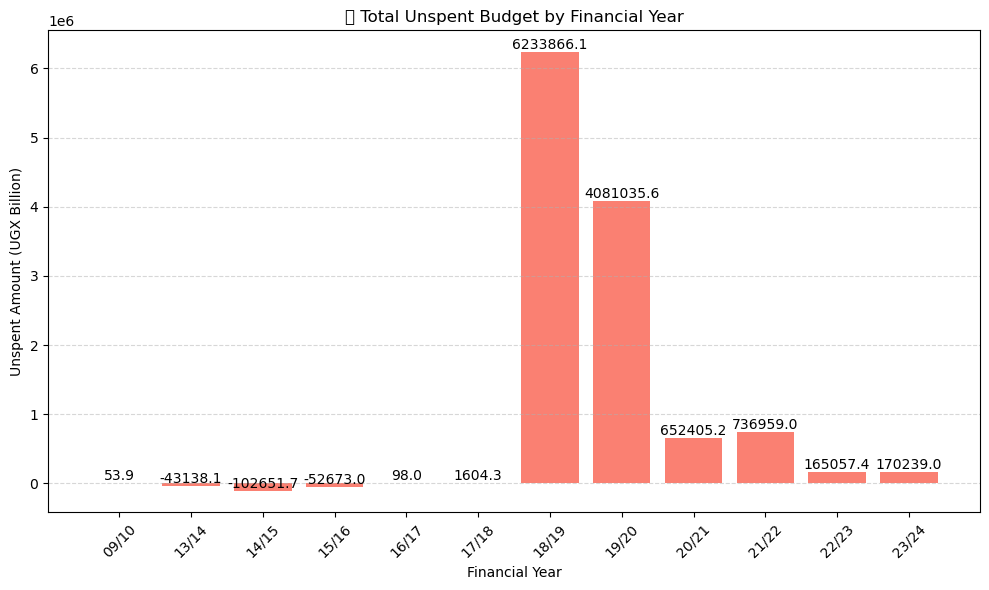

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx"
df = pd.read_excel(file_path)

# Ensure Deviation and FY are clean
df = df[df["Deviation (UGX)"].notna() & df["Financial Year"].notna()]

# Group and sum by Financial Year
deviation_by_year = df.groupby("Financial Year")["Deviation (UGX)"].sum().sort_index()

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(deviation_by_year.index, deviation_by_year.values / 1e9, color="salmon")
plt.title("💸 Total Unspent Budget by Financial Year")
plt.xlabel("Financial Year")
plt.ylabel("Unspent Amount (UGX Billion)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\ambyb\AppData\Local\Temp\ipykernel_9748\2351373519.py:28: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


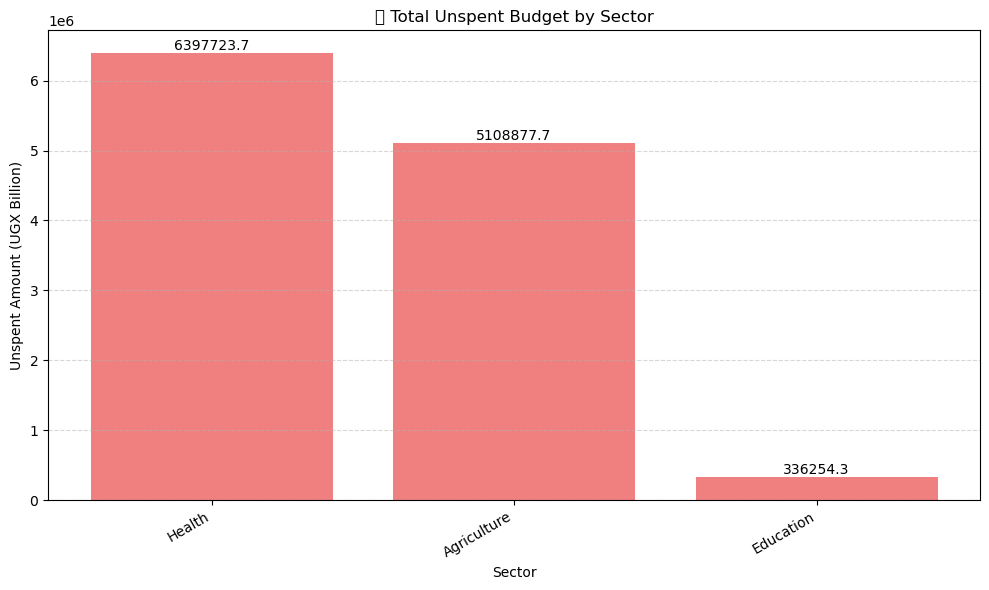

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx"
df = pd.read_excel(file_path)

# Clean and filter
df = df[df["Deviation (UGX)"].notna() & df["Sector"].notna()]

# Group by Sector
deviation_by_sector = df.groupby("Sector")["Deviation (UGX)"].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(deviation_by_sector.index, deviation_by_sector.values / 1e9, color="lightcoral")
plt.title("💸 Total Unspent Budget by Sector")
plt.xlabel("Sector")
plt.ylabel("Unspent Amount (UGX Billion)")
plt.xticks(rotation=30, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


C:\Users\ambyb\AppData\Local\Temp\ipykernel_9748\1382762834.py:26: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


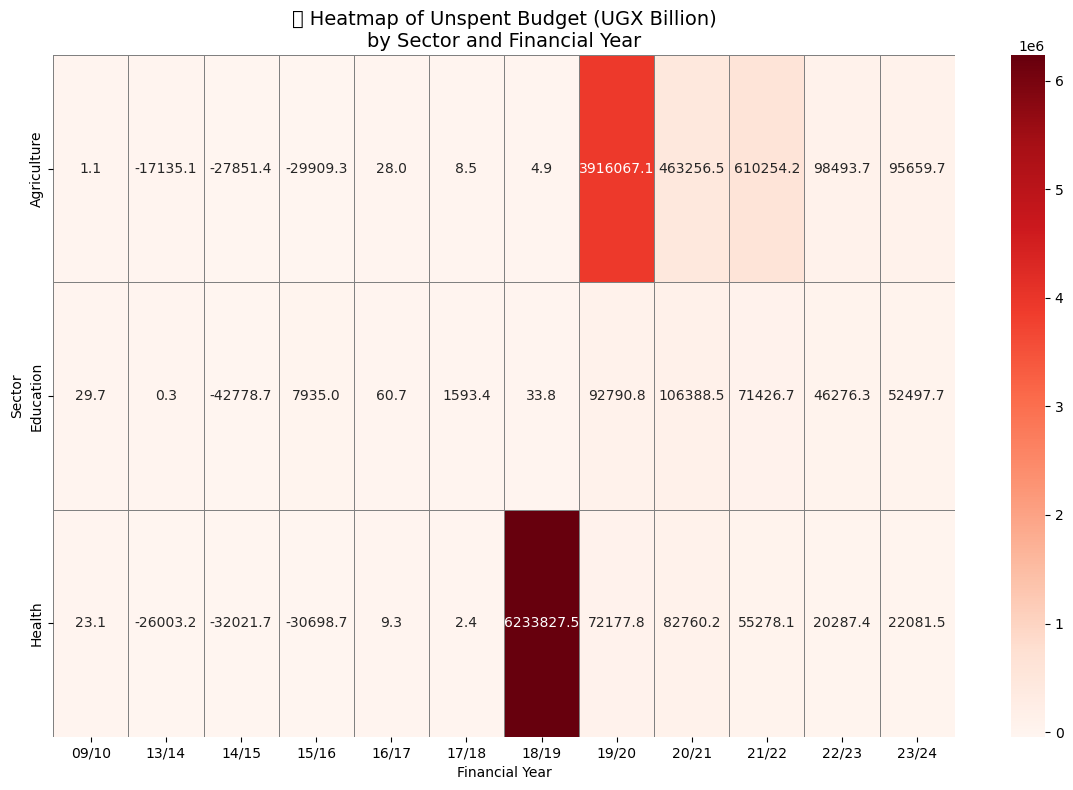

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your Excel file
file_path = r"C:\Users\ambyb\Desktop\Budgeting\Budget_Performance_Data_Imputed_Colored.xlsx"
df = pd.read_excel(file_path)

# Clean data: keep only rows with Deviation and both grouping keys
df_clean = df[df["Deviation (UGX)"].notna() & df["Sector"].notna() & df["Financial Year"].notna()]

# Create pivot table: Sectors x Years with deviation sums
pivot = df_clean.pivot_table(
    index="Sector",
    columns="Financial Year",
    values="Deviation (UGX)",
    aggfunc="sum"
) / 1e9  # Convert to billions

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Reds", linewidths=0.5, linecolor='gray')
plt.title("🔥 Heatmap of Unspent Budget (UGX Billion)\nby Sector and Financial Year", fontsize=14)
plt.xlabel("Financial Year")
plt.ylabel("Sector")
plt.tight_layout()
plt.show()
